#ACGAN for Classification and Generation

This is done on the *Terra Sigillata* Dataset.

###Part 1: Imports

In [ ]:
!pip install torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 51.5 MB/s eta 0:00:00


In [ ]:
!pip install torch-fidelity

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torchvision import transforms

from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
import shutil
import tempfile
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
import logging
from pathlib import Path

import os
import cv2
import glob

from sklearn.metrics import accuracy_score
from torchmetrics.image.fid import FrechetInceptionDistance

from tqdm import tqdm

In [ ]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.0 MB/s eta 0:00:00


In [ ]:
import monai

from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandRotate90d,
    RandSpatialCropd,
    ScaleIntensityd,
    Resized,
    EnsureChannelFirstd,

    RandFlipd,
    RandRotate90d,
    RandRotateD,
)

###Part 2: Helper Functions

In [ ]:
def reorganize_dataset(dataset_path):
    dataset_path = Path(dataset_path)

    if not dataset_path.exists():
        print(f"The dataset path '/content/dataset' does not exist.")
        return

    if not dataset_path.is_dir():
        print(f"The dataset path '/content/dataset' is not a directory.")
        return

    for class_folder in dataset_path.iterdir():
        if class_folder.is_dir():
            print(f"Processing class folder: {class_folder.name}")

            for sample_folder in class_folder.iterdir():
                if sample_folder.is_dir():
                    print(f"  Processing sample folder: {sample_folder.name}")

                    for image_file in sample_folder.iterdir():
                        if image_file.is_file() and image_file.suffix.lower() in ['.jpg', '.jpeg']:
                            new_image_name = f"{sample_folder.name}_{image_file.name}"
                            destination = class_folder / new_image_name

                            counter = 1
                            while destination.exists():
                                new_image_name = f"{sample_folder.name}_{image_file.stem}_{counter}{image_file.suffix}"
                                destination = class_folder / new_image_name
                                counter += 1

                            try:
                                shutil.move(str(image_file), str(destination))
                                print(f"    Moved: {image_file.name} -> {new_image_name}")
                            except Exception as e:
                                print(f"    Failed to move {image_file.name}: {e}")

                    try:
                        sample_folder.rmdir()
                        print(f"  Removed empty sample folder: {sample_folder.name}")
                    except OSError:
                        print(f"  Sample folder not empty or cannot be removed: {sample_folder.name}")

    print("Dataset reorganization complete.")


In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    return image

def create_orange_mask(image, threshold_B):
    threshold_B = int(threshold_B)
    threshold_B = max(0, min(threshold_B, 255))

    if len(image.shape) == 2 or image.shape[2] != 3:
        raise ValueError(f"Expected a 3-channel image, but got shape: {image.shape}")

    lower_orange = np.array([threshold_B, 100, 100], dtype=image.dtype)
    upper_orange = np.array([255, 255, 255], dtype=image.dtype)

    mask = cv2.inRange(image, lower_orange, upper_orange)
    return mask

def extract_largest_region(mask):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels <= 1:
        return mask
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    largest_mask = (labels == largest_label).astype(np.uint8) * 255
    return largest_mask

def fill_mask_holes(mask):
    filled_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    return filled_mask

def process_image(image_path, image_save_dir, mask_save_dir, resize_dim=(224, 224)):
    try:
        logging.info(f"Processing image: {image_path}")

        image = load_image(image_path)
        image_resized = cv2.resize(image, dsize=resize_dim, interpolation=cv2.INTER_CUBIC)
        logging.debug(f"Resized image shape: {image_resized.shape}")

        class_folder = os.path.basename(os.path.dirname(image_path))
        image_filename = os.path.basename(image_path)
        image_output_dir = os.path.join(image_save_dir, class_folder)
        os.makedirs(image_output_dir, exist_ok=True)
        image_output_path = os.path.join(image_output_dir, image_filename)
        cv2.imwrite(image_output_path, image_resized)
        logging.debug(f"Saved resized image to: {image_output_path}")

        threshold = np.percentile(image_resized, 15)
        mask = create_orange_mask(image_resized, threshold_B=threshold)
        largest_mask = extract_largest_region(mask)
        filled_mask = fill_mask_holes(largest_mask).astype(np.uint8) * 255
        unique_values = np.unique(filled_mask)
        logging.debug(f"Unique values in mask: {unique_values}")

        mask_output_dir = os.path.join(mask_save_dir, class_folder)
        os.makedirs(mask_output_dir, exist_ok=True)
        mask_output_path = os.path.join(mask_output_dir, image_filename)
        cv2.imwrite(mask_output_path, filled_mask)
        logging.debug(f"Saved mask to: {mask_output_path}")

        logging.info(f"Finished processing: {image_path}")
        return True

    except Exception as e:
        logging.error(f"Error processing {image_path}: {e}")
        return False


In [ ]:
def get_class_mapping(data_dir):
  classes = [d.name for d in os.scandir(data_dir) if d.is_dir()]
  classes.sort()

  class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

  return class_to_idx

###Part 2 Dataset

In [ ]:
!unzip /content/drive/MyDrive/archaide.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Dr18/A10151/f_A10151_20191205_111414.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._f_A10151_20191205_111414.jpg  
  inflating: dataset/Dr18/A10151/f_A10151_20191205_111401.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._f_A10151_20191205_111401.jpg  
  inflating: dataset/Dr18/A10151/t_A10151_20191205_111223.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._t_A10151_20191205_111223.jpg  
  inflating: dataset/Dr18/A10151/s_A10151_20191205_111232.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._s_A10151_20191205_111232.jpg  
  inflating: dataset/Dr18/A10151/t_A10151_20191205_111154.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._t_A10151_20191205_111154.jpg  
  inflating: dataset/Dr18/A10151/s_A10151_20191205_111148.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._s_A10151_20191205_111148.jpg  
  inflating: dataset/Dr18/A10151/s_A10151_20191205_111228.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._s_A1015

In [ ]:
#Reorganizing the Dataset
dataset_dir = "/content/dataset"
image_save_dir = '/content/data/image'
mask_save_dir = '/content/data/mask'

os.makedirs(image_save_dir, exist_ok=True)
os.makedirs(mask_save_dir, exist_ok=True)

reorganize_dataset(dataset_dir)

In [ ]:
def create_mask():
  image_paths = []
  for folder in glob.glob(os.path.join(dataset_dir, '*')):
    folder_images = glob.glob(os.path.join(folder, '*jpg'))[:400]
    image_paths.extend(folder_images)
  total_images = len(image_paths)

  num_workers = min(32, os.cpu_count() + 4)

  with ProcessPoolExecutor(max_workers=num_workers) as executor:
    process_func = partial(
        process_image,
        image_save_dir=image_save_dir,
        mask_save_dir=mask_save_dir
    )

    futures = {executor.submit(process_func, img_path): img_path for img_path in image_paths}

    with tqdm(total=total_images, desc="Processing Images", unit="image") as pbar:
        processed = 0
        successes = 0
        for future in as_completed(futures):
            img_path = futures[future]
            result = future.result()
            processed += 1
            if result:
                successes += 1
            pbar.update(1)
            pbar.set_postfix({"Successes": successes})

create_mask()

Processing Images: 100%|██████████| 3021/3021 [00:14<00:00, 210.54image/s, Successes=3021]


###Part 3: Creating the GAN Model

The Generator Model will combine the input class images and the noise vector z to form the input. It will then upsample the image through 5 layers until reaching a one-channeled grayscale image, which will be the output.

The Discrimiantor Model will take the input grayscale image from the Generator model, extract features with two layers of downsampling, and output a binary and classification output. The realfake head will output a binary number representing the model's prediction for the realism of the image and a classification tensor representing the model's predicted image class of the generated output.

The overall architecture is that of a **Auxiliary Classifier GAN**, where:
- The Generator creates fake images conditioned on the latent noise and class labels. It outputs a grayscale image.
- The Discriminator classifes the grayscale images both as real or fake and predicts the class.

The idea behind the architecture is that the model will be able to learn features during the generating process that will translate to classification.

This is similar to the unet classifier model. Instead of learning through segmentation, it'll be learning through generation. This can make for an interesting comparison.

In [ ]:
class Generator(nn.Module):

  def __init__(self, z_dim, num_classes=9, embed_dim=50):
    super().__init__()
    self.z_dim = z_dim
    self.num_classes = num_classes
    self.embed_dim = embed_dim

    self.embed = nn.Embedding(num_classes, embed_dim)

    #This is the code that combines the noise vector and the class image.
    self.fc = nn.Sequential(
        nn.Linear(z_dim+embed_dim, 7*7*256),
        nn.ReLU(True)
    )

    self.gen = nn.Sequential(
        nn.Unflatten(1, (256, 7, 7)),

        nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(True),

        nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(True),

        nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
        nn.Tanh(),
    )

  def forward(self, z, labels):
    embedded_labels = self.embed(labels)
    x = torch.cat([z, embedded_labels], dim=1)
    x = self.fc(x)
    x = self.gen(x)
    return x

In [ ]:
class Discriminator(nn.Module):

  def __init__(self, num_classes=9):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Flatten()
    )

    self.realfake_head = nn.Linear(401408, 1)
    self.class_head    = nn.Linear(401408, num_classes)

  def forward(self, x):
    feature = self.features(x)
    out_rf = self.realfake_head(feature)
    out_cls = self.class_head(feature)
    return out_rf, out_cls

In [ ]:
generator = Generator(100, 9)
discriminator = Discriminator(9)

epoch_num = 10
num_classes=9

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

###Part 4: Getting Class Keys

In [ ]:
data_dir = '/content/data/image'
class_to_idx = get_class_mapping(data_dir)
print(class_to_idx, class_to_idx.keys())

{'Dr18': 0, 'Dr24-25': 1, 'Dr27': 2, 'Dr29': 3, 'Dr33': 4, 'Dr35': 5, 'Dr36': 6, 'Dr37': 7, 'Dr38': 8} dict_keys(['Dr18', 'Dr24-25', 'Dr27', 'Dr29', 'Dr33', 'Dr35', 'Dr36', 'Dr37', 'Dr38'])


###Part 5: The Training Loop

In [ ]:
class GANDataset(Dataset):

  def __init__(self, images, segs, class_to_idx, transform=None):
    self.image_paths = images
    self.mask_paths = segs
    self.class_to_idx = class_to_idx
    self.transform = transform

  def __len__(self):
    return len(self.mask_paths)

  def __getitem__(self, idx):
    image_filepath = self.image_paths[idx]
    mask_filepath = self.mask_paths[idx]

    data = {
        "image": image_filepath,
        "mask": mask_filepath
    }

    if self.transform is not None:
      data = self.transform(data)

    image = data["image"]
    mask = data["mask"]
    class_name = os.path.basename(os.path.dirname(image_filepath))
    label = self.class_to_idx.get(class_name, -1)
    if label == -1:
        raise ValueError(f"can't find the class name.")

    return image, mask, label

The shape of z: torch.Size([64, 100])
Epoch [0/10] Batch 0/48 Loss D: 5.8768, Loss G: 24.9749
g_cls_loss: 6.3683, cls_loss_real: 2.3497, cls_loss_fake: 2.2280
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The s

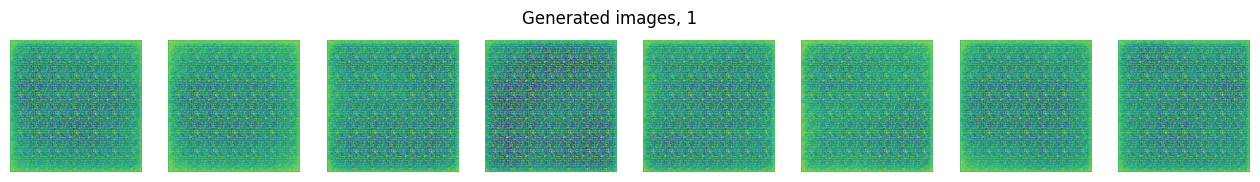

The shape of z: torch.Size([64, 100])
Epoch [1/10] Batch 0/48 Loss D: 26.4403, Loss G: 23.5717
g_cls_loss: 12.6484, cls_loss_real: 11.7671, cls_loss_fake: 14.0967
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
T

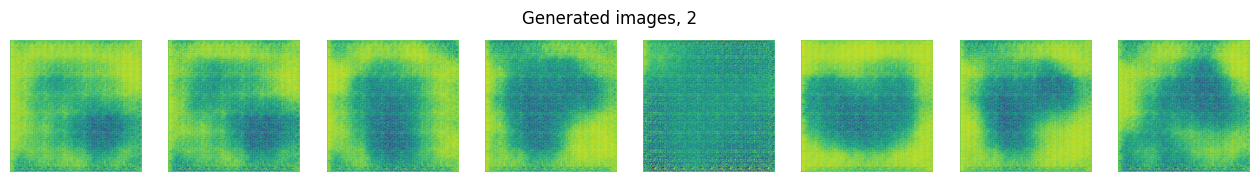

The shape of z: torch.Size([64, 100])
Epoch [2/10] Batch 0/48 Loss D: 10.4268, Loss G: 12.7577
g_cls_loss: 2.1987, cls_loss_real: 8.7278, cls_loss_fake: 0.2122
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The 

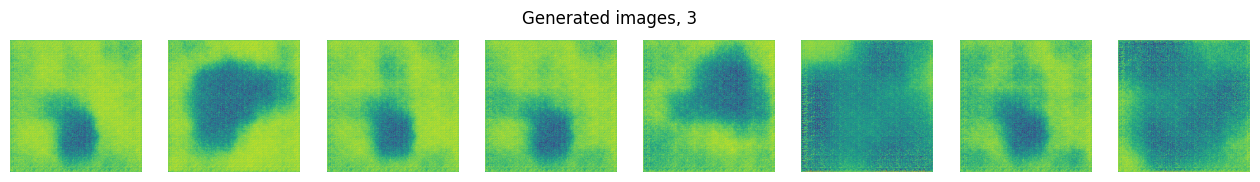

The shape of z: torch.Size([64, 100])
Epoch [3/10] Batch 0/48 Loss D: 28.1145, Loss G: 11.7544
g_cls_loss: 1.0979, cls_loss_real: 21.9406, cls_loss_fake: 0.2288
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The

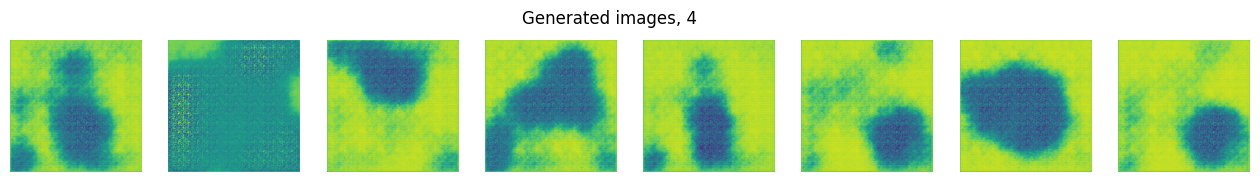

The shape of z: torch.Size([64, 100])
Epoch [4/10] Batch 0/48 Loss D: 18.3623, Loss G: 18.5462
g_cls_loss: 0.0044, cls_loss_real: 14.8986, cls_loss_fake: 0.0939
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The

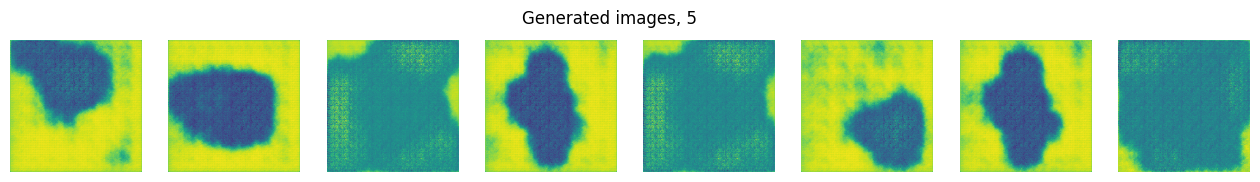

The shape of z: torch.Size([64, 100])
Epoch [5/10] Batch 0/48 Loss D: 13.8191, Loss G: 2.0428
g_cls_loss: 0.0009, cls_loss_real: 7.0856, cls_loss_fake: 0.0420
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The s

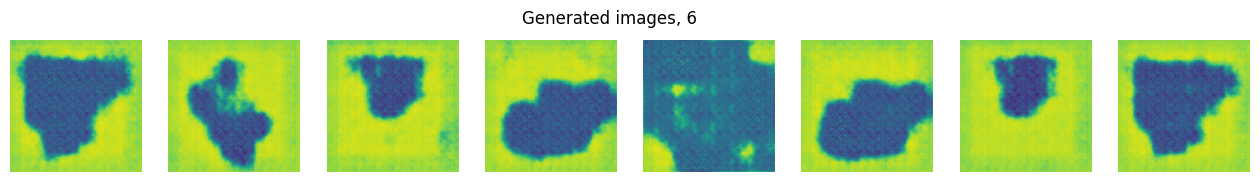

The shape of z: torch.Size([64, 100])
Epoch [6/10] Batch 0/48 Loss D: 15.8051, Loss G: 14.5264
g_cls_loss: 0.0177, cls_loss_real: 13.5569, cls_loss_fake: 0.4415
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The

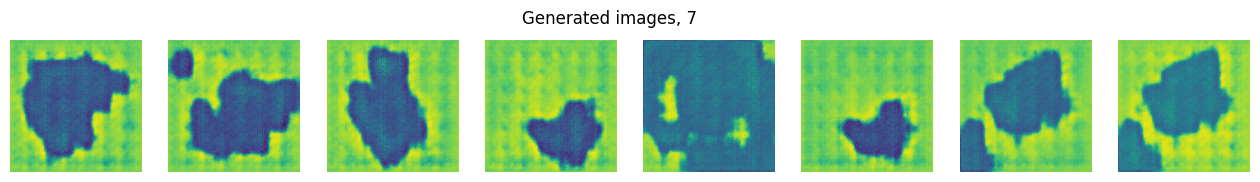

The shape of z: torch.Size([64, 100])
Epoch [7/10] Batch 0/48 Loss D: 16.6300, Loss G: 27.2648
g_cls_loss: 1.2840, cls_loss_real: 12.1287, cls_loss_fake: 2.7559
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The

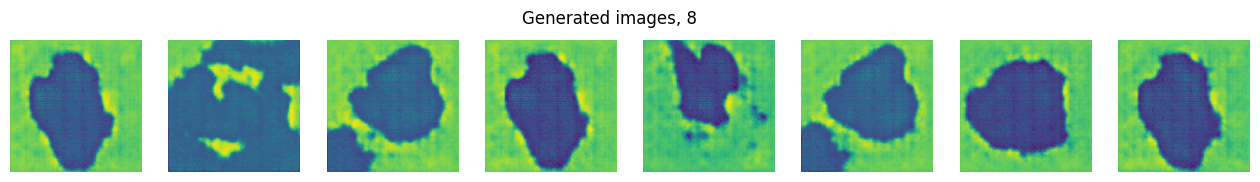

The shape of z: torch.Size([64, 100])
Epoch [8/10] Batch 0/48 Loss D: 23.3028, Loss G: 24.5212
g_cls_loss: 2.1963, cls_loss_real: 18.8041, cls_loss_fake: 1.8723
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The

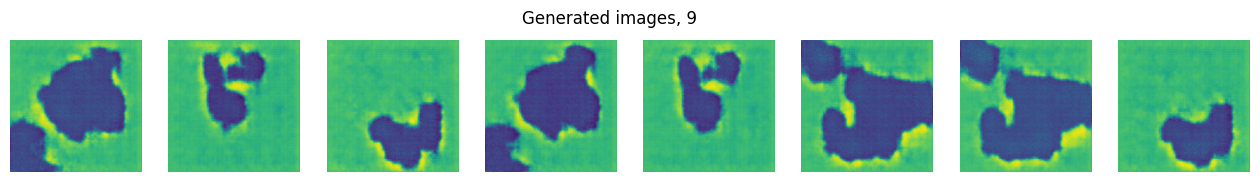

The shape of z: torch.Size([64, 100])
Epoch [9/10] Batch 0/48 Loss D: 8.9137, Loss G: 3.5019
g_cls_loss: 0.0015, cls_loss_real: 7.6949, cls_loss_fake: 0.0003
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The shape of z: torch.Size([64, 100])
The sh

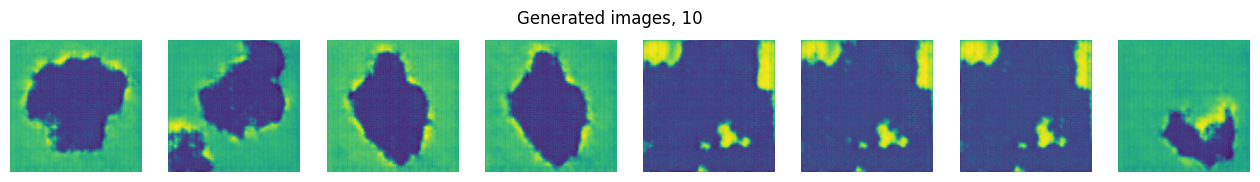

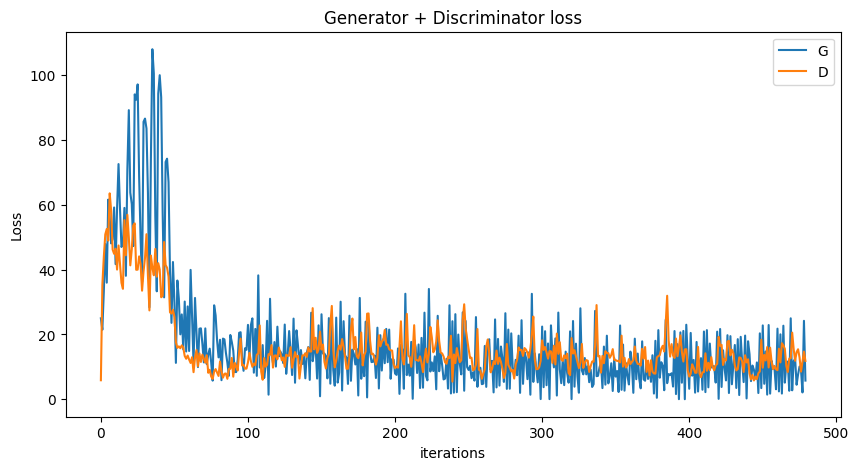

In [ ]:
def main(tempdir):

  image_save_dir = '/content/data/image'
  mask_save_dir = '/content/data/mask'

  images = sorted(glob.glob(os.path.join(image_save_dir, "*/*.jpg")))
  segs = sorted(glob.glob(os.path.join(mask_save_dir, "*/*.jpg")))

  TARGET_SIZE = (224, 224) #I don't think we need this anymore.

  loss_adv = nn.BCEWithLogitsLoss()
  loss_cls = nn.CrossEntropyLoss()

  generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
  discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

  train_transforms = Compose([
      LoadImaged(keys=["image", "mask"], image_only=False),
      EnsureChannelFirstd(keys=["image", "mask"]),
      ScaleIntensityd(keys=["image", "mask"]),
      Resized(spatial_size=TARGET_SIZE, keys=["image", "mask"], mode=["bilinear", "nearest"]),

      RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
      RandRotate90d(keys=["image", "mask"], prob=0.5, max_k=3),
      RandRotateD(keys=["image", "mask"], range_x=np.pi/4, prob=0.5),
  ])

  val_transforms = Compose([
      LoadImaged(keys=["image", "mask"], image_only=False),
      EnsureChannelFirstd(keys=["image", "mask"]),
      ScaleIntensityd(keys=["image", "mask"]),
      Resized(spatial_size=TARGET_SIZE, keys=["image", "mask"], mode=["bilinear", "nearest"])
  ])

  train_ds = GANDataset(segs, segs, class_to_idx, train_transforms) #Only using masks
  train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available()
    )

  val_ds = GANDataset(segs, segs, class_to_idx, val_transforms) #Same thing above
  val_loader = DataLoader(
      val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available()
      )

  z_dim=100
  g_losses = []
  d_losses = []

  for epoch in range(epoch_num):

    generator.train()
    discriminator.train()

    for batch_idx, (images, masks, labels) in enumerate(train_loader):

      #Discriminator

      discriminator.zero_grad()
      b_size = images.size(0)

      real_images = images.to(device)
      real_labels = labels.to(device)
      #Real is represented as a list of ones while fakes are represented as a list of zeros.
      label_real_rf = torch.ones(b_size, 1, device=device)
      label_fake_rf = torch.zeros(b_size, 1, device=device)

      #Label used here - training the discriminatro on real images
      out_rf_real, out_cls_real = discriminator(real_images)
      adv_loss_real = loss_adv(out_rf_real, label_real_rf)
      cls_loss_real = loss_cls(out_cls_real, real_labels)

      z = torch.randn(b_size, z_dim, device=device)
      print("The shape of z:", z.shape)
      # fake_labels = torch.randint(0, num_classes, (b_size,), device=device)
      # fixed_noise = torch.randn(batch_size, z_dim, device=device)

      fake_labels = torch.randint(0, num_classes, (b_size,), device=device)
      fixed_noise = torch.randn(b_size, z_dim, device=device)

      fake_images = generator(z, fake_labels)

      #THIS IS THE BULK OF THE MINMAX GAME ============================

      #Labels used here - training the discriminator on fake images
      out_rf_fake, out_cls_fake = discriminator(fake_images.detach()) #Training the discriminator
      adv_loss_fake = loss_adv(out_rf_fake, label_fake_rf) #Train the discriminator to identify the fake images as fake (FAKE, FAKE)
      cls_loss_fake = loss_cls(out_cls_fake, fake_labels)

      loss_D = adv_loss_real + cls_loss_real + adv_loss_fake + cls_loss_fake

      loss_D.backward()
      discriminator_optimizer.step()

      #Generator

      generator.zero_grad()
      out_rf_fake_g, out_cls_fake_g = discriminator(fake_images) #Training the generator

      g_adv_loss = loss_adv(out_rf_fake_g, label_real_rf) #Drive the discriminator to think that the fake images are real (FAKE, REAL). Also, we want to maximize this loss.
      g_cls_loss = loss_cls(out_cls_fake_g, fake_labels)

      loss_G = g_adv_loss + g_cls_loss
      loss_G.backward()
      generator_optimizer.step()

      #===================================================================

      #Recording loss
      g_losses.append(loss_G.item())
      d_losses.append(loss_D.item())

      if batch_idx % 50 == 0:
        print(f"Epoch [{epoch}/{epoch_num}] Batch {batch_idx}/{len(train_loader)} "
              f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
        print(f"g_cls_loss: {g_cls_loss.item():.4f}, cls_loss_real: {cls_loss_real.item():.4f}, cls_loss_fake: {cls_loss_fake.item():.4f}")

    #Validation

    generator.eval()
    with torch.no_grad():
      fake_images_fixed = generator(fixed_noise, fake_labels).cpu()

    fig, axes = plt.subplots(1, 8, figsize=(16, 2))
    for i in range(8):
        axes[i].imshow((fake_images_fixed[i].permute(1, 2, 0) * 0.5 + 0.5).numpy())
        axes[i].axis("off")
    plt.suptitle(f"Generated images, {epoch+1}")
    plt.show()

  #Visualization

  plt.figure(figsize=(10,5))
  plt.title("Generator + Discriminator loss")
  plt.plot(g_losses, label="G")
  plt.plot(d_losses, label="D")
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

if __name__ == "__main__":
    with tempfile.TemporaryDirectory() as tempdir:
        main(tempdir)

In [ ]:
def eval():

  z_dim = 100

  image_save_dir = '/content/data/image'
  mask_save_dir = '/content/data/mask'

  images = sorted(glob.glob(os.path.join(image_save_dir, "*/*.jpg")))
  segs = sorted(glob.glob(os.path.join(mask_save_dir, "*/*.jpg")))

  TARGET_SIZE = (224, 224) #I don't think we need this anymore.

  val_transforms = Compose([
      LoadImaged(keys=["image", "mask"], image_only=False),
      EnsureChannelFirstd(keys=["image", "mask"]),
      ScaleIntensityd(keys=["image", "mask"]),
      Resized(spatial_size=TARGET_SIZE, keys=["image", "mask"], mode=["bilinear", "nearest"])
  ])

  val_ds = GANDataset(segs, segs, class_to_idx, val_transforms) #Same thing above
  val_loader = DataLoader(
      val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available()
      )

  fid = FrechetInceptionDistance().to(device)
  generator.eval()
  discriminator.eval()

  real_images_list = []
  fake_images_list = []
  all_preds = []
  all_labels = []

  with torch.no_grad():

    for batch_idx, (images, masks, labels) in enumerate(val_loader):

      b_size = images.size(0)
      real_images = images.to(device)
      real_labels = labels.to(device)

      z = torch.randn(b_size, z_dim, device=device)
      fake_labels = torch.randint(0, num_classes, (b_size,), device=device)
      fake_images = generator(z, fake_labels)

      out_rf_real, out_cls_real = discriminator(real_images)
      real_class_preds = torch.argmax(out_cls_real, dim=1)

      real_images_list.append(real_images)
      fake_images_list.append(fake_images)

      all_preds.extend(real_class_preds.cpu().numpy())
      all_labels.extend(real_labels.cpu().numpy())

  real_images_tensor = torch.cat(real_images_list, dim=0)
  fake_images_tensor = torch.cat(fake_images_list, dim=0)
  fid = FrechetInceptionDistance().to(device)

  #Resizing and converting to 3-channeled input (since fid only accepts RGB images)
  real_images_tensor = (real_images_tensor * 255).clamp(0, 255).byte()
  fake_images_tensor = (fake_images_tensor * 255).clamp(0, 255).byte()
  real_images_tensor = real_images_tensor.repeat(1, 3, 1, 1)
  fake_images_tensor = fake_images_tensor.repeat(1, 3, 1, 1)

  fid.update(real_images_tensor, real=True)
  fid.update(fake_images_tensor, real=False)
  fid_score = fid.compute()

  accuracy = accuracy_score(all_labels, all_preds)

  print(f"FID score: {fid_score:.4f}")
  print(f"Classification accuracy: {accuracy:.4f}")

eval()

OutOfMemoryError: CUDA out of memory. Tried to allocate 15.56 GiB. GPU 0 has a total capacity of 39.56 GiB of which 4.62 GiB is free. Process 51344 has 34.94 GiB memory in use. Of the allocated memory 25.97 GiB is allocated by PyTorch, and 8.46 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)